### 1.  Libraries Import

In [272]:
import yfinance as yf    ## yahoo finance for stock data
import numpy as np      
import pandas as pd
import seaborn as sns    ## for Vizualization
import matplotlib.pyplot as plt           ## for Vizualization
from sklearn.preprocessing import MinMaxScaler   ## For scaling the data

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout   ## importing layers of Neural network
from keras.callbacks import ModelCheckpoint     ## imporing modelcheck pointer
from keras.losses import MSE                  ## importing error function
from keras.optimizers import Adam              ## importing optimizer
from keras.activations import relu           ## importing activation function
import os

sns.set()

### 2. Loading in Dataset

######    i)   Stock data used TSLA (Tesla)
######   ii)   From 06/29/2010 (i.e. TSLA's IPO Date ) to 06/20/2019
######  iii)   Data is of 24 hr interval

In [273]:
import matplotlib.pyplot as plt
df = yf.download('TSLA','2010-06-29','2019-05-28',interval='1d')


[*********************100%***********************]  1 of 1 downloaded


In [274]:
df1 = df.copy() 

In [275]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900


### 3. Preprocessing and Feature Extraction

I will be predicting the opening of TSLA stock 

In [276]:
df = df['Open'].values
print("Total No. of days of TSLA's Stocks :",df.shape[0])

Total No. of days of TSLA's Stocks : 2243


#### Splitting the data into train test split

In [277]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print('Training stock :',dataset_train.shape[0],'days')
print('Test stock :',dataset_test.shape[0],'days')

Training stock : 1794 days
Test stock : 499 days


#### Scaling the data

a) Train Data

In [278]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train.reshape(-1, 1))


b) Test Data

In [279]:
dataset_test = scaler.transform(dataset_test.reshape(-1, 1))


In [280]:
def create_dataset(df,n):
    '''
    Function to prepare data for the LSTM
    
    '''
    
    x = []
    y = []
  
    for i in range(n, df.shape[0]):
        x.append(df[i-n:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y 

In [281]:
x_train, y_train = create_dataset(dataset_train,50)


In [282]:
x_test, y_test = create_dataset(dataset_test,50)


#### Reshape features for LSTM Layer

In [283]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [284]:
print('Training data shape',x_train.shape)
print('Test data shape',x_test.shape)


Training data shape (1744, 50, 1)
Test data shape (449, 50, 1)


### 4. Building Model

In [294]:
model = Sequential()

model.add(LSTM(units=96, 
               return_sequences=True,
               input_shape=(x_train.shape[1], 1)))

model.add(Dropout(0.2))

model.add(LSTM(units=96, 
               return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units=96, 
               return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(units=96))

model.add(Dropout(0.2))

model.add(Dense(units=1))

In [295]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 50, 96)            37632     
_________________________________________________________________
dropout_49 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_50 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 50, 96)            74112     
_________________________________________________________________
dropout_51 (Dropout)         (None, 50, 96)            0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 96)                74112     
__________

In [296]:
model.compile(loss=MSE, optimizer=Adam())

In [297]:
checkpointer = ModelCheckpoint(filepath='tesla.stock_prediction.hdf5',save_best_only=True,verbose=1)

callbacks = [checkpointer]

In [298]:

history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,callbacks=[checkpointer],validation_split=0.05)


Train on 1656 samples, validate on 88 samples
Epoch 1/70
1656/1656 [==============================] - 21s 13ms/step - loss: 0.0134 - val_loss: 0.0186

Epoch 00001: val_loss improved from inf to 0.01856, saving model to tesla.stock_prediction.hdf5
Epoch 2/70
1656/1656 [==============================] - 14s 9ms/step - loss: 0.0023 - val_loss: 0.0077

Epoch 00002: val_loss improved from 0.01856 to 0.00775, saving model to tesla.stock_prediction.hdf5
Epoch 3/70
1656/1656 [==============================] - 15s 9ms/step - loss: 0.0021 - val_loss: 0.0101

Epoch 00003: val_loss did not improve from 0.00775
Epoch 4/70
1656/1656 [==============================] - 14s 9ms/step - loss: 0.0023 - val_loss: 0.0173

Epoch 00004: val_loss did not improve from 0.00775
Epoch 5/70
1656/1656 [==============================] - 14s 9ms/step - loss: 0.0024 - val_loss: 0.0128

Epoch 00005: val_loss did not improve from 0.00775
Epoch 6/70
1656/1656 [==============================] - 14s 9ms/step - loss: 0.0023 

1656/1656 [==============================] - 15s 9ms/step - loss: 8.6555e-04 - val_loss: 9.8072e-04

Epoch 00049: val_loss did not improve from 0.00096
Epoch 50/70
1656/1656 [==============================] - 15s 9ms/step - loss: 8.3307e-04 - val_loss: 0.0024

Epoch 00050: val_loss did not improve from 0.00096
Epoch 51/70
1656/1656 [==============================] - 15s 9ms/step - loss: 8.1061e-04 - val_loss: 0.0021

Epoch 00051: val_loss did not improve from 0.00096
Epoch 52/70
1656/1656 [==============================] - 15s 9ms/step - loss: 7.4218e-04 - val_loss: 0.0037

Epoch 00052: val_loss did not improve from 0.00096
Epoch 53/70
1656/1656 [==============================] - 15s 9ms/step - loss: 8.1519e-04 - val_loss: 7.6832e-04

Epoch 00053: val_loss improved from 0.00096 to 0.00077, saving model to tesla.stock_prediction.hdf5
Epoch 54/70
1656/1656 [==============================] - 15s 9ms/step - loss: 9.1173e-04 - val_loss: 0.0012

Epoch 00054: val_loss did not improve from 0.0

In [299]:
model = load_model('tesla.stock_prediction.hdf5')

#### Best model saved as 'tesla.stock_prediction.hdf5'

### 5. Visualizing Results

#### Plotting the Predicted Stock Price with True Stock Price

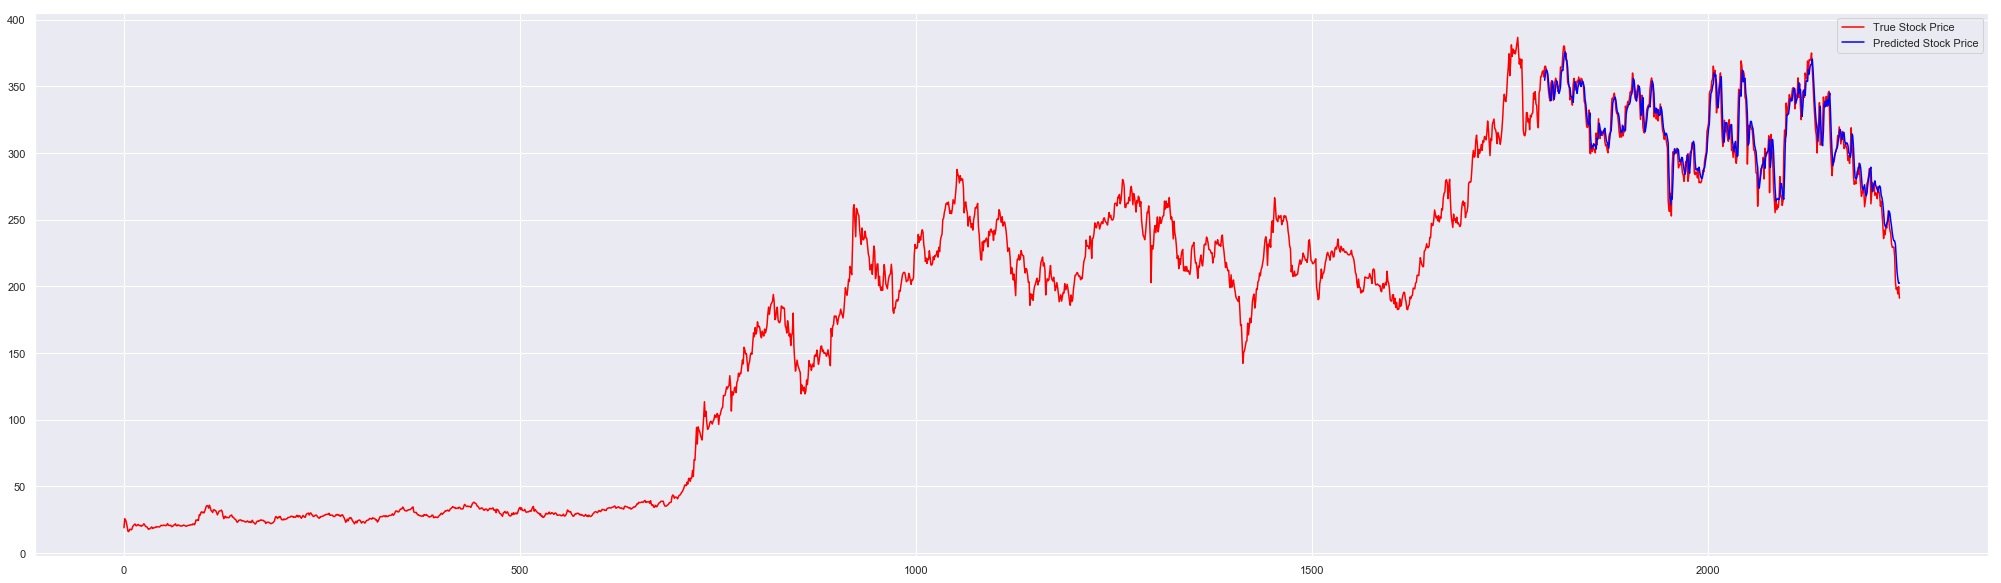

In [300]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(35,10))
plt.plot(df, color='red',  label="True Stock Price",)
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Stock Price')
plt.legend()



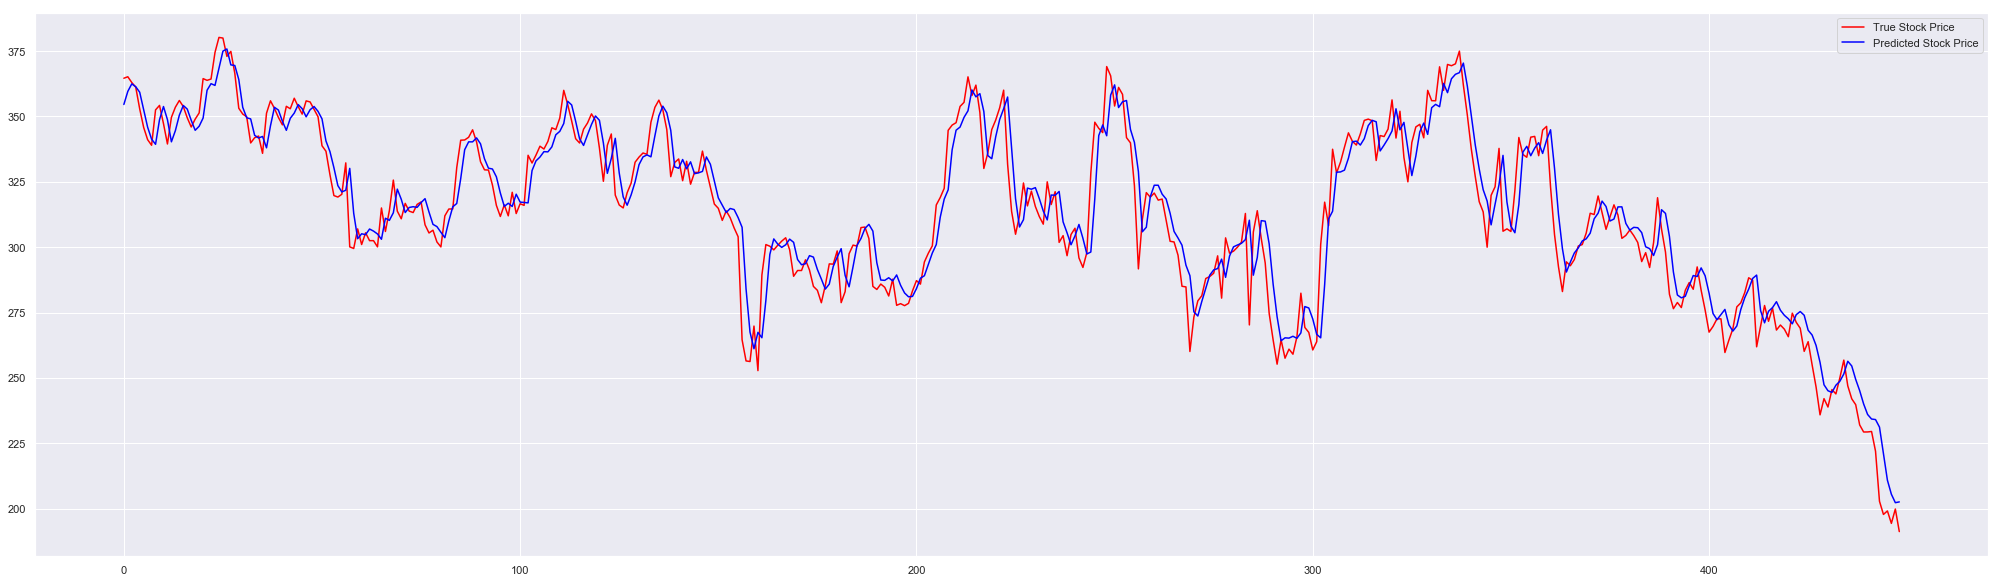

In [301]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


fig, ax = plt.subplots(figsize=(35,10))
ax.plot(y_test_scaled, color='red', label='True Stock Price')
plt.plot(predictions, color='blue', label='Predicted Stock Price')
plt.legend()

The Graph looks beautiful !!

## 6. Evaluation

In [309]:
df1.reset_index(inplace=True)
comparison = df1[['Date','Open']].iloc[len(y_train)+50:] 
comparison['Predictions'] = predictions


In [303]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [310]:
mean_absolute_error(comparison['Open'],comparison['Predictions'])
 

7.785530182088669